In [1]:
import os
import glob
import time
import shutil

import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn import metrics

In [2]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, root, label_path, transform=None):
        self.transform = transform
        self.labels = pd.read_csv(label_path)
        self.root = root
        self.types = ("FLAIR", "T1w", "T1wCE", "T2w")

    
    def __getitem__(self, idx):
        brats21id = self.labels.iloc[idx]["BraTS21ID"]
        mgmt_value = self.labels.iloc[idx]["MGMT_value"]
        
        patient_path = os.path.join(self.root, str(int(brats21id)).zfill(5))
        t_paths = sorted(
            glob.glob(os.path.join(patient_path, self.types[0], "*")), 
            key=lambda x: int(x[:-4].split("-")[-1]),
        )
        
        t_data = []
        for i in np.linspace(0,len(t_paths)-1,15):
            data = load_dicom(t_paths[int(i)])
            t_data.append(data)
        t_data = np.stack(t_data, axis=2)
        if self.transform:
            t_data = self.transform(t_data)
        return t_data, float(mgmt_value)
    
    
    def __len__(self):
        return self.labels.shape[0]

In [4]:
root = "../input/rsna-miccai-brain-tumor-radiogenomic-classification"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.RandomResizedCrop(224),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
#     normalize
])

train_dataset = BrainTumorDataset(os.path.join(root, "train"),
                                  os.path.join(root, "train_labels.csv"),
                                  train_transform)

train_loader = DataLoader(
        train_dataset, batch_size=32, shuffle=True,
        num_workers=4, pin_memory=True)

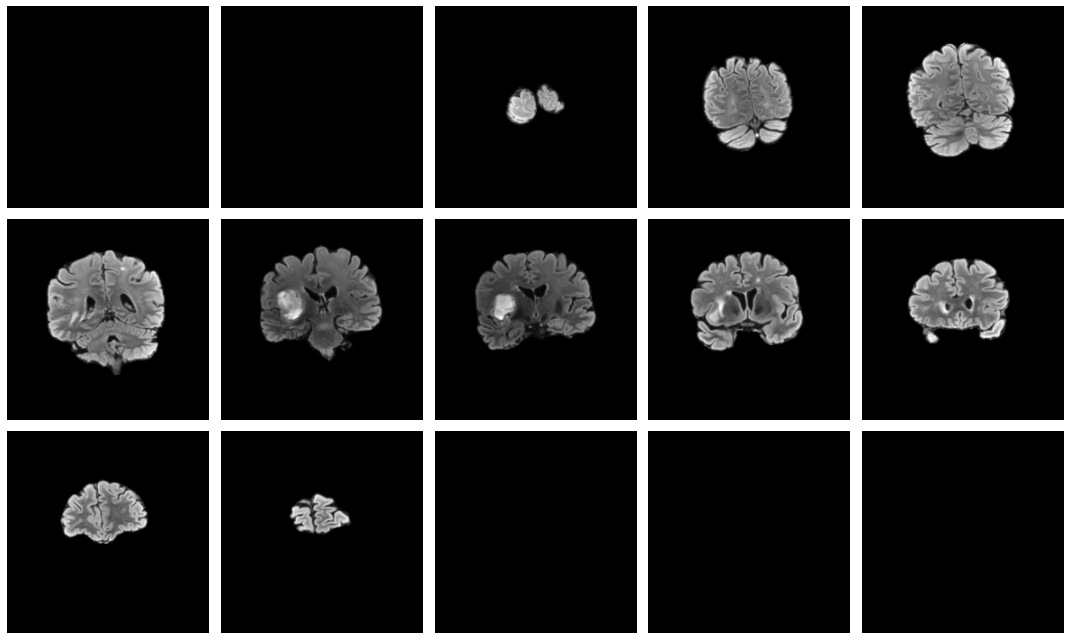

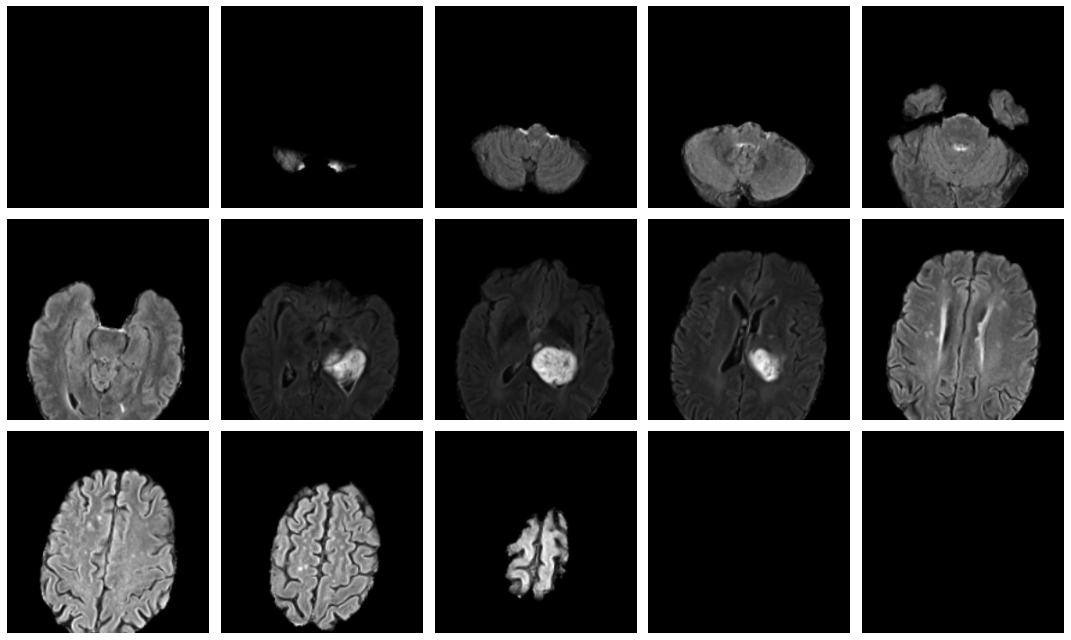

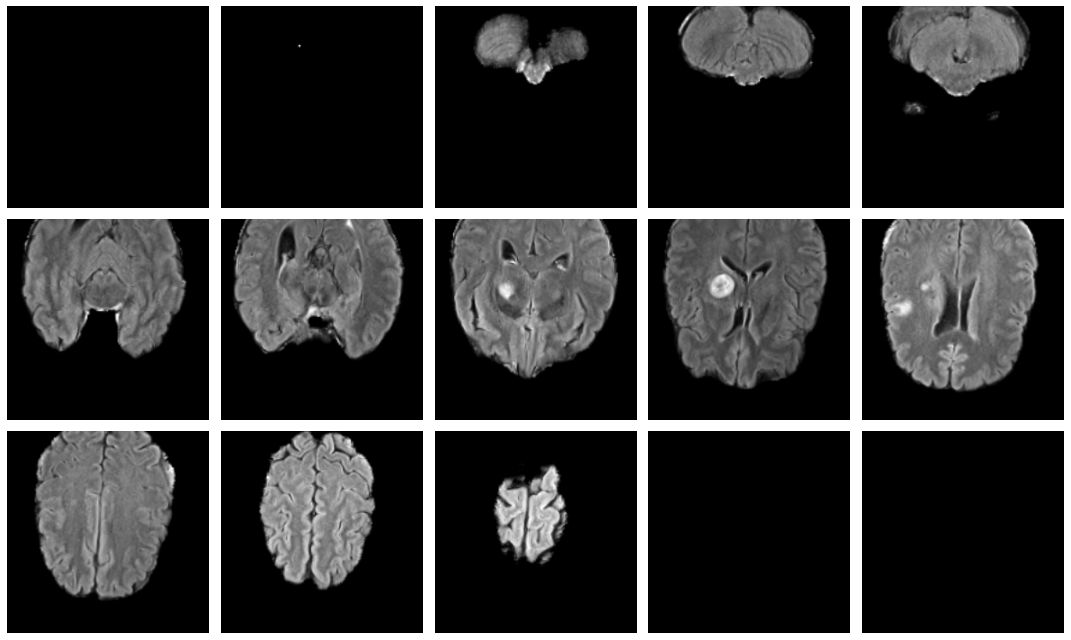

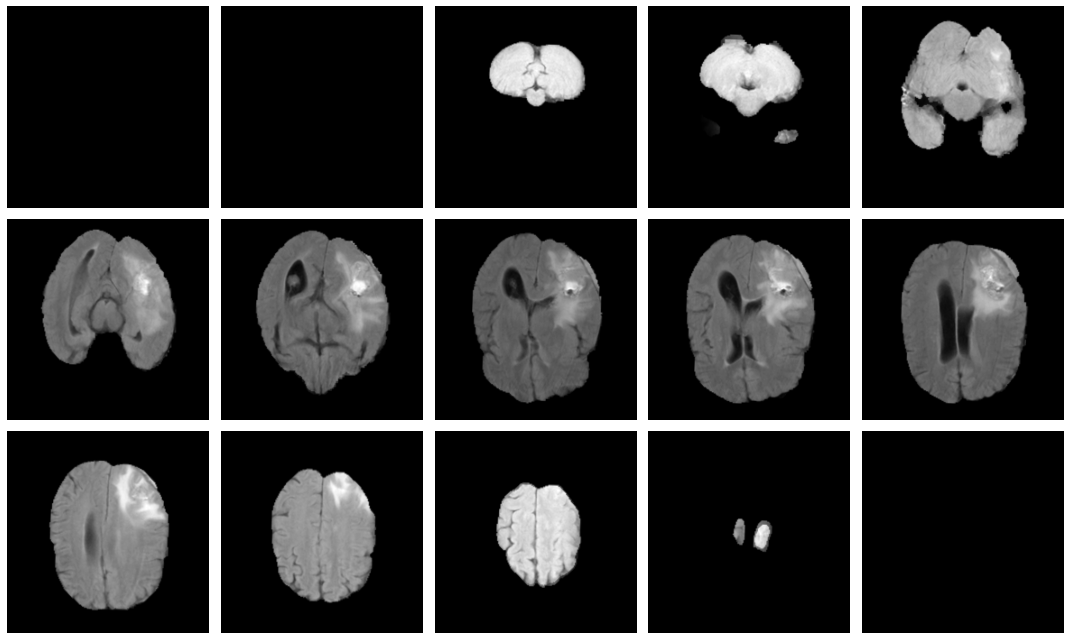

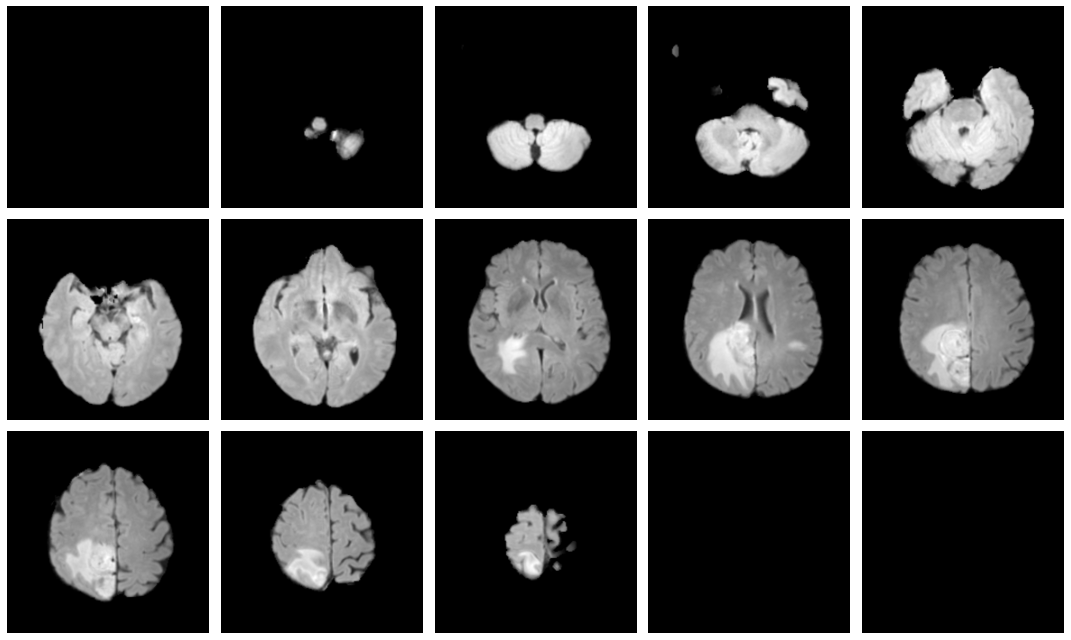

In [5]:
def visualize(image3d):
    fig, ax = plt.subplots(3, 5, figsize=(15, 9))
    for i, img in enumerate(image3d):
        ax[i // 5][i % 5].imshow(img, cmap="gray")
        ax[i // 5][i % 5].axis('off')
    plt.tight_layout()

example_batch = next(iter(train_loader))
for i in range(5):
    visualize(example_batch[0][i])

In [6]:
def train(train_loader, model, criterion, optimizer, epoch, device):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    acc = AverageMeter('Acc', ':6.2f')
    auc = AverageMeter('AUC', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, acc, auc],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        
        images = images.to(device)
        target = target.to(device)

        # compute output
        output = model(images).squeeze(1)
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), images.size(0))
        acc.update(accuracy(output, target), images.size(0))
        auc.update(roc_auc(output, target), images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()


        progress.display(i)


def validate(val_loader, model, criterion, device):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    acc = AverageMeter('Acc', ':6.2f')
    auc = AverageMeter('AUC', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, acc, auc],
        prefix='Val: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            images = images.to(device)
            target = target.to(device)
            
            # compute output
            output = model(images).squeeze(1)
            loss = criterion(output, target)

            # measure accuracy and record loss
            losses.update(loss.item(), images.size(0))
            acc.update(accuracy(output, target), images.size(0))
            auc.update(roc_auc(output, target), images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            progress.display(i)

        print(' * Auc {auc.avg:.3f} Acc {acc.avg:.3f}'.format(auc=auc, acc=acc))

    return auc.avg

def test(test_loader, model, device):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(test_loader),
        [batch_time],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    
    scores = []

    with torch.no_grad():
        end = time.time()
        for i, (images, _) in enumerate(test_loader):
            images = images.to(device)
            
            # compute output
            output = model(images).squeeze(1)
            
            scores.extend(torch.sigmoid(output).cpu().numpy())
            
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            progress.display(i)
            
    return scores

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def adjust_learning_rate(optimizer, epoch, initial_lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = initial_lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target):
    """Computes the accuracy for threshold of 0"""
    with torch.no_grad():
        batch_size = target.size(0)
        pred = (output >= 0).to(torch.float32)
        correct = pred.eq(target).float().sum()
        return correct / batch_size

    
def roc_auc(output, target):
    """Computes the accuracy for threshold of 0"""
    with torch.no_grad():
        scores = torch.sigmoid(output)
        return metrics.roc_auc_score(target.cpu().numpy(), scores.cpu().numpy())

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = models.resnet50()
model.conv1 = nn.Conv2d(15, model.conv1.out_channels, model.conv1.kernel_size,
                        model.conv1.stride, model.conv1.padding, bias=model.conv1.bias)
model.fc = nn.Linear(model.fc.in_features, 1)

model = model.to(device)
# print(model)

criterion = nn.BCEWithLogitsLoss().to(device)

optimizer = torch.optim.SGD(model.parameters(), 0.001,
                            momentum=0.95,
                            weight_decay=1e-5)

cuda


In [8]:
best_auc = 0

for epoch in range(10):
    adjust_learning_rate(optimizer, epoch, 0.1)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch, device)

    # evaluate on validation set
    auc = validate(train_loader, model, criterion, device)

    # remember best acc@1 and save checkpoint
    is_best = auc > best_auc
    best_auc = max(auc, best_auc)

    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'resnet50',
        'state_dict': model.state_dict(),
        'best_auc': best_auc,
        'optimizer' : optimizer.state_dict(),
    }, is_best)

Epoch: [0][ 0/19]	Time 10.621 (10.621)	Data 10.214 (10.214)	Loss 7.1486e-01 (7.1486e-01)	Acc   0.53 (  0.53)	AUC   0.48 (  0.48)
Epoch: [0][ 1/19]	Time  0.227 ( 5.424)	Data  0.027 ( 5.121)	Loss 5.4754e+00 (3.0951e+00)	Acc   0.38 (  0.45)	AUC   0.61 (  0.54)
Epoch: [0][ 2/19]	Time  0.262 ( 3.703)	Data  0.015 ( 3.419)	Loss 4.7242e+01 (1.7811e+01)	Acc   0.41 (  0.44)	AUC   0.47 (  0.52)
Epoch: [0][ 3/19]	Time  0.120 ( 2.807)	Data  0.004 ( 2.565)	Loss 3.4949e+01 (2.2095e+01)	Acc   0.44 (  0.44)	AUC   0.40 (  0.49)
Epoch: [0][ 4/19]	Time  9.666 ( 4.179)	Data  9.510 ( 3.954)	Loss 2.4818e+00 (1.8173e+01)	Acc   0.47 (  0.44)	AUC   0.54 (  0.50)
Epoch: [0][ 5/19]	Time  0.247 ( 3.524)	Data  0.080 ( 3.308)	Loss 1.1553e+01 (1.7069e+01)	Acc   0.53 (  0.46)	AUC   0.42 (  0.49)
Epoch: [0][ 6/19]	Time  0.238 ( 3.054)	Data  0.056 ( 2.844)	Loss 3.2723e+01 (1.9306e+01)	Acc   0.38 (  0.45)	AUC   0.50 (  0.49)
Epoch: [0][ 7/19]	Time  0.198 ( 2.697)	Data  0.051 ( 2.495)	Loss 2.8198e+01 (2.0417e+01)	Acc   0.

In [9]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224)
#     normalize
])

test_dataset = BrainTumorDataset(os.path.join(root, "test"),
                                  os.path.join(root, "sample_submission.csv"),
                                  test_transform)

test_loader = DataLoader(
        test_dataset, batch_size=32,
        num_workers=4, pin_memory=True)

In [10]:
scores = test(test_loader, model, device)

ids = test_dataset.labels["BraTS21ID"].tolist()

submission = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": scores})
submission.to_csv("submission.csv", index=False)



Test: [0/3]	Time  7.277 ( 7.277)
Test: [1/3]	Time  0.059 ( 3.668)
Test: [2/3]	Time  0.046 ( 2.461)


In [11]:
submission

,BraTS21ID,MGMT_value
0,1,0.521893
1,13,0.521853
2,15,0.521905
3,27,0.521882
4,37,0.521983
...,...,...
82,826,0.487532
83,829,0.521719
84,833,0.521748
85,997,0.521889
